In [1]:
# TODO add Electraseed cut of initial investment logic

# Electraseed Energy Financial Model - Version 1: Anchor

## Purpose
The energy financial model version 1 evaluates the financial performance of an aggregated pool of loans to clean energy developers, and the resulting outcomes for the investor, the developers, the Electraseed Fund, and any 3rd party actors.

## Structure
The basic structure is comprised of the following components:  

**Inputs**  
* Library Import  
* Input Definition  

**Actors**  
* Actor Class Definition  
* Actor Creation  

**Loan Creations**  
* Loan Menu Creation  
* Portfolio Optimizer  
* Loan Matching  

**Investment Projections**  
* Investment Math  
* Risk Projections  

**Outputs**  
* Output Aggregation  
* Output Dashboard

## Energy Model

### Library Import
Import libraries requried for energy financial model

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import random
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

### Input Definition
Inputs are entered here as described above

In [3]:
# Invididual Energy Asset Information
# TODO2 get names of individual projects
# TODO2 get actual numbers
dea_names = ['Polarstern', 'MaxSolar', 'Solartainer', 'SOLShare'] # name of dea
dea_locations = ['Germany', 'Germany', 'Mali', 'Bangladesh'] # location of dea
dea_classifications = ['developed', 'developed', 'developing', 'developing'] # classification of economy
dea_loansizerequests = [2000000,1000000,700000,500000] # euros loan requested
dea_rateappetites = [0.04, 0.07, 0.10, 0.16] # % annual interest appetite
dea_defaultrates = [0.04, 0.05, 0.15, 0.20] # % annual risk of default
dea_paymentfreqs = [1, 1, 1, 12] # months between interest payments
dea_loanperiods = [15, 15, 10, 15] # years of loan period

# Investor Information
investor_names = ['inv_altruistic', 'inv_impact1', 'inv_impact2', 'inv_impact3', 'inv_monopolyman'] # name of investor
investor_investment_requests = [1000000, 1000000, 1000000, 1000000, 1000000] # euros investment
investor_ratefloors = [0.00, 0.05, 0.04, 0.03, 0.07] # % annual interest minimum
investor_riskappetites = [0.08, 0.04, 0.06, 0.06, 0.02] # % annual risk of default
investor_riskfreerates = [0.01, 0.01, 0.01, 0.01, 0.01]

# Underwriter Information
uw_names = ['uw_Germany', 'uw_Mali', 'uw_Bang1', 'uw_Bang2']
uw_locations = ['Germany', 'Mali', 'Bangladesh', 'Bangladesh']
uw_maxloans = [5000000, 600000, 200000, 400000] # euros max underwrite
uw_rateinvs = [0.03, 0.09, 0.11, 0.11] # % annual interest rate OFFER
uw_ratedeas = [0.035, 0.10, 0.12, 0.12] # % annual interest minimum LOAN OUT
uw_riskappetites = [0.03, 0.15, 0.15, 0.15] # % annual risk of default appetite

# spv Information
spv_names = 'Electraseed'
spv_interestratios = [0.15]

# NPV Calculation
NPV_rate = 0.01

# Covariance Values for estimated covariance definition
location_same_cov = 0.15 # cov impact if in same location
location_dif_cov = 0. # cov impact if in different location
classification_same_cov = 0.15 # cov impact if same classification
classification_dif_cov = -0.1 # cov impact if different classification
same_borrower_dif_cov = 0.9

### Actor Class Definition
Define digital energy asset, investor, and other actor classes

In [4]:
# Digital Energy Asset (DEA) class
class dea_: 
    def __init__(self, name, location, classification, loansizerequest, rateappetite, defaultrate, paymentfreq, loanperiod):
        # attributes
        self.name = name
        self.location = location
        self.classification = classification
        self.loansizerequest = loansizerequest
        self.rateappetite = rateappetite
        self.defaultrate = defaultrate
        self.paymentfreq = paymentfreq
        self.loanperiod = loanperiod
        # loan tracking
        self.activeloanamount = 0
        self.indexnum = None
        # TODO3 add energy data
        
# Investor class
class investor_:
    def __init__(self, name, investment_request, ratefloor, riskappetite, riskfreerate):
        self.name = name
        self.investment_request = investment_request
        self.ratefloor = ratefloor
        self.riskappetite = riskappetite
        self.riskfreerate = riskfreerate
        # TODO2 add optimization metric
        
# Underwriter class
class underwriter_:
    def __init__(self, name, location, maxloan, rateinv, ratedea, riskappetite):
        self.name = name
        self.location = location
        self.maxloan = maxloan
        self.rateinv = rateinv
        self.ratedea = ratedea
        self.riskappetite = riskappetite
        # loan tracking
        self.activedealoanamount = 0
        self.activespvloanamount = 0
        
# Elecraseed class
class spv_:
    def __init__(self, name, interestratio):
        self.name = name
        self.interestratio = interestratio

### Actor Creation
Create the actual entities involved in our ecosystem, filling out their appropriate attributes.  
Each of the entities are placed in a list of all existing entities of that class

In [5]:
# Digital Energy Assets
deas = []
for i in range(len(dea_names)):
    deas.append(dea_(dea_names[i], dea_locations[i], dea_classifications[i], dea_loansizerequests[i], dea_rateappetites[i], dea_defaultrates[i], dea_paymentfreqs[i], dea_loanperiods[i]))
    deas[i].indexnum = i # set index num for later reference
    
# Investors
investors = []
for i in range(len(investor_names)):
    investors.append(investor_(investor_names[i], investor_investment_requests[i], investor_ratefloors[i], investor_riskappetites[i], investor_riskfreerates[i]))

# Underwriters
underwriters = []
for i in range(len(uw_locations)):
    underwriters.append(underwriter_(uw_names[i], uw_locations[i], uw_maxloans[i], uw_rateinvs[i], uw_ratedeas[i], uw_riskappetites[i]))

# spvs
spvs = [spv_(spv_names, spv_interestratios)]


### Loan Menu Creation
Create the 'menu' of loans available to investors  
#### Create the Loan Class

In [6]:
# Loan class
class subloan_:
    def __init__(self, investor, rateinv_precut, rateinv_postcut, amount):
        self.investor = investor
        self.rateinv_precut = rateinv_precut
        self.rateinv_postcut = rateinv_postcut
        self.amount = amount
        # payment tracker
        # inv precut
        self.payment_inv_precut = None
        self.payment_interest_inv_precut = []
        self.payment_principal_inv_precut = []
        # inv postcut
        self.payment_inv_postcut = None
        self.payment_interest_inv_postcut = []
        self.payment_principal_inv_postcut = []
        
        
class loan_:
    def __init__(self, dea, underwriter, amount, ratedea, paymentfreq, loanperiod, defaultrate):
        self.dea = dea
        self.underwriter = underwriter
        self.amount = amount
        self.ratedea = ratedea
        self.paymentfreq = paymentfreq
        self.loanperiod = loanperiod
        self.defaultrate = defaultrate
        # loan tracking
        self.amountfinanced = 0
        self.subloans = []
        # payment tracker
        # dea
        self.payment_dea = None
        self.payment_interest_dea = []
        self.payment_principal_dea = []

#### Loan Requests Fracturing and Loan Menu Creation
Fracture the loan requests based on the underwriter's loan offerings.  
Add each of these to a loan 'menu' to pair with investors

In [7]:
# Underwriter - DEA loan matching

# match deas to underwriters if loan is possible
loan_menu = []
total_loan_amount_requested = 0
total_amount_in_loan_options = 0
for dea in deas:
    total_loan_amount_requested += dea.loansizerequest
    if dea.activeloanamount < dea.loansizerequest: # check if loan needed
        for underwriter in underwriters:
            # TODO2 add sorting script for loan rates
            if underwriter.location == dea.location: # check if eligible to loan
                if underwriter.ratedea <= dea.rateappetite: # check rate eligible
                    ratedea = underwriter.ratedea # rate is underwriters offer to dea
                    rateinv = underwriter.rateinv
                    amount = min(underwriter.maxloan-underwriter.activedealoanamount, dea.loansizerequest-dea.activeloanamount) # amount is what dea asks for or max underwriter offer
                    loan = loan_(dea, underwriter, amount, ratedea, dea.paymentfreq, dea.loanperiod, dea.defaultrate)
                    underwriter.activedealoanamount += amount # track active loans
                    dea.activeloanamount += amount # track active loan amount
                    total_amount_in_loan_options += amount #
                    loan_menu.append(loan) # track active loans in loan menu

print("Total loan amount requested:", total_loan_amount_requested)
print("Number of loan options created:", len(loan_menu))
print("Total loan amount fundable:", total_amount_in_loan_options)

Total loan amount requested: 4200000
Number of loan options created: 5
Total loan amount fundable: 4100000


#### Covariance Matrix Definition
Create the covariance matrix for risk of the projected loans

In [8]:
# Create covariance matrix
def covariance_matrix_creator(loans):
    cov_matrix = np.zeros((len(loans), len(loans))) # initialize covariance matrix
    for i in range(len(loans)):
        for j in range(i, len(loans)):
            if i == j: 
                cov_matrix[i][j] = 1 # set diagonal to 1
            else:
                if loans[i].dea.name == loans[j].dea.name: # check if same name
                    cov_matrix[i][j] = same_borrower_dif_cov
                    cov_matrix[j][i] = same_borrower_dif_cov
                else:
                    if loans[i].dea.location == loans[j].dea.location: # check for location cov
                        cov_matrix[i][j] += location_same_cov
                        cov_matrix[j][i] = cov_matrix[i][j]
                    else:
                        cov_matrix[i][j] += location_dif_cov
                        cov_matrix[j][i] = cov_matrix[i][j]
                    if loans[i].dea.classification == loans[j].dea.classification: # check for economy classification cov
                        cov_matrix[i][j] += classification_same_cov
                        cov_matrix[j][i] = cov_matrix[i][j]
                    else:
                        cov_matrix[i][j] += classification_dif_cov
                        cov_matrix[j][i] = cov_matrix[i][j]
    return cov_matrix

cov_matrix = covariance_matrix_creator(loan_menu)

### Portfolio Optimizer Definition
Before we can match loans to investors, we need to create 'optimal' portfolio math based on investor-specific inputs

In [9]:
# define function to calculate portfolio performance
def portfolio_performance(weights, returns, stds, cov_matrix):
    p_ret = np.sum(weights * np.asarray(returns)) # calculate return
    # calculate std using 'modern portfolio theory', calculations available on wiki
    p_std = 0 
    for i in range(len(weights)): # summation of each weights^2 and std^2
        p_std += (weights[i]**2)*(stds[i])**2
    for i in range(len(weights)): # summation of covariance calculation
        for j in range(len(weights)):
            if i != j:
                p_std += weights[i]*weights[j]*stds[i]*stds[j]*cov_matrix[i][j]
    p_std = np.sqrt(p_std) # sqrt for variance --> std
    # TODO check risk calculation for type of loan
    return p_std, p_ret

# define function to get sharpe ratio for optimization measure
def neg_sharpe_ratio(weights, returns, stds, cov_matrix, risk_free_rate):
    p_std, p_ret = portfolio_performance(weights, returns, stds, cov_matrix) # get std and return
    return -(p_ret - risk_free_rate) / p_std # calculate sharpe ratio

#TODO define function to get social / environmental optimization

# define function to find optimal portfolio weights
def portfolio_optimizer(loan_menu, cov_matrix, investor, return_rates, stds, amounts):
    # TODO2 optimize for impact
    # TODO2 instead return efficient frontier, maybe then can optimize further for impact?
    # set investor investment amount to min amount remaining against requested amount
    investor.investment = min(investor.investment_request, np.sum(amounts))
    num_assets = len(loan_menu)
    args = (return_rates, stds, cov_matrix, investor.riskfreerate)
    # set helper functions for constraints
    def portfolio_risk(weights):
        return portfolio_performance(weights, return_rates, stds, cov_matrix)[0]
    def portfolio_return(weights):
        return portfolio_performance(weights, return_rates, stds, cov_matrix)[1]
    # define constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, # weights sum to 1
                   {'type': 'ineq', 'fun': lambda x: amounts - x * investor.investment}, # investor investment <= requested loan amount
                   {'type': 'ineq', 'fun': lambda x: investor.riskappetite - portfolio_risk(x)}, # portfolio risk <= investor risk appetite
                   {'type': 'ineq', 'fun': lambda x: portfolio_return(x) - investor.ratefloor}) # portfolio return >= investor rate floor
                   
    bound = (0.0, 1.0) # set bounds for the portfolio weights
    bounds = tuple(bound for asset in range(num_assets))
    # run actual optimization on negative sharpe ratio (will move to impact ratio)
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def optimize_portfolio(loan_menu, cov_matrix, investor, return_rates, return_rates_investor, stds, amounts):
    opt = portfolio_optimizer(loan_menu, cov_matrix, investor, return_rates_investor, stds, amounts) # get optimal portfolio base on inputs
    weights = opt.x # extract output weights
    # print some relevant outputs
    print('--------')
    print('investor:', investor.name)
    print('investment:',np.round(investor.investment),"of",investor.investment_request,"requested")
    print('risk tol:', investor.riskappetite, 'rate floor:', investor.ratefloor, 'risk free:', investor.riskfreerate)
    if opt.success:
        print('optimal portfolio found:')
    else:
        print('not all constraints met. Best we could do:')
    p_std, p_ret = portfolio_performance(weights, return_rates, stds, cov_matrix) # get optimal portfolio performance
    print('\ttot_risk:',np.round(p_std*100,2),'%,', 'tot_return:',np.round(p_ret*100,2),'%,', 'tot_sharpe:', np.round((p_ret-investor.riskfreerate)/p_std,2))
    p_std, p_ret = portfolio_performance(weights, return_rates_investor, stds, cov_matrix) # get optimal portfolio performance
    print('\tinv_risk:',np.round(p_std*100,2),'%,', 'inv_return:',np.round(p_ret*100,2),'%,', 'inv_sharpe:', np.round((p_ret-investor.riskfreerate)/p_std,2))
    print('\tportfolio weights', np.round(weights,2))
    print('\tportfolio investments', np.round(weights*investor.investment))
    print('\tloan requested', np.round(amounts))
    return opt.success, weights

### SPV Business Case
Addd tool to adjust rate that investor sees to allow for SPV revenue from interest payments. 

In [10]:
# calculate new interest rate for investor based on spv cut
def investor_interest_after_spv_cut(rates, spv):
    investor_rates = np.asarray(rates) * (1.-spv.interestratio[0]) # cut interest rates by ratio
    return investor_rates

### Loan Matching
Tinder for loans

In [11]:
# run portfolio optimization for each investor

# next iterate through each investor to find optimal portfolio
for investor in investors:
    # first get return rates, stds, and loan amounts requested from the loan options
    return_rates = []
    stds = []
    amounts = []
    for loan_option in loan_menu:
        amount = loan_option.amount - loan_option.amountfinanced # get loan amount requested
        amounts.append(amount)
        # if there is no more money requested, make that loan give 0% return to trick model
        if amount > 1:
            return_rates.append(loan_option.underwriter.rateinv) # get return rate for investors
            stds.append(loan_option.defaultrate) # get risk rate
        else:
            return_rates.append(0.)
            stds.append(1.)
    return_rates_investor = investor_interest_after_spv_cut(return_rates, spvs[0])
    # optimize the portfolio under the constraints
    success, weights = optimize_portfolio(loan_menu, cov_matrix, investor, return_rates, return_rates_investor, stds, amounts)
    # update investor tracker
    investor.bestportfolio = weights
    investor.optimalportfoliofound = success
    # update loan menu with amount invested
    i = 0
    for loan_option in loan_menu:
        amount = weights[i] * investor.investment
        loan_option.amountfinanced += amount
        rateinv_postcut = investor_interest_after_spv_cut(loan_option.underwriter.rateinv, spvs[0])
        subloan = subloan_(investor, loan_option.underwriter.rateinv, rateinv_postcut, amount)
        if subloan.amount >= 1:
            loan_option.subloans.append(subloan)
        i += 1
    # TODO adjust loan menu based on investment
    

--------
investor: inv_altruistic
investment: 1000000 of 1000000 requested
risk tol: 0.08 rate floor: 0.0 risk free: 0.01
optimal portfolio found:
	tot_risk: 3.83 %, tot_return: 4.72 %, tot_sharpe: 0.97
	inv_risk: 3.83 %, inv_return: 4.01 %, inv_sharpe: 0.79
	portfolio weights [0.48 0.27 0.14 0.05 0.05]
	portfolio investments [475807. 273155. 144083.  53477.  53477.]
	loan requested [2000000 1000000  600000  200000  300000]
--------
investor: inv_impact1
investment: 1000000 of 1000000 requested
risk tol: 0.04 rate floor: 0.05 risk free: 0.01
not all constraints met. Best we could do:
	tot_risk: 5.46 %, tot_return: 5.88 %, tot_sharpe: 0.89
	inv_risk: 5.46 %, inv_return: 5.0 %, inv_sharpe: 0.73
	portfolio weights [0.36 0.23 0.24 0.09 0.09]
	portfolio investments [355661. 225116. 235718.  91753.  91753.]
	loan requested [1524193.  726845.  455917.  146523.  246523.]
--------
investor: inv_impact2
investment: 1000000 of 1000000 requested
risk tol: 0.06 rate floor: 0.04 risk free: 0.01
opti

### Investment Math
Calculate payments and amortization schedule, to define which parties are getting which amounts at which time.
#### Loan Status  
Print existing loan information for reference

In [12]:
# print useful information about loans and subloans
for loan in loan_menu:
    print("dea:",loan.dea.name,", underwriter:",loan.underwriter.name)
    print("financed:",np.round(loan.amountfinanced),"of",loan.amount,"with",len(loan.subloans),"subloans:")
    for subloan in loan.subloans:
        print("\t","investor:",subloan.investor.name,"amount:",np.round(subloan.amount),"rate_precut:",subloan.rateinv_precut,"rate_postcut:",subloan.rateinv_postcut)
    print("-----------")
        

dea: Polarstern , underwriter: uw_Germany
financed: 2000000.0 of 2000000 with 5 subloans:
	 investor: inv_altruistic amount: 475807.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact1 amount: 355661.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact2 amount: 475876.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact3 amount: 592657.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_monopolyman amount: 100000.0 rate_precut: 0.03 rate_postcut: 0.0255
-----------
dea: MaxSolar , underwriter: uw_Germany
financed: 1000000.0 of 1000000 with 4 subloans:
	 investor: inv_altruistic amount: 273155.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact1 amount: 225116.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact2 amount: 273133.0 rate_precut: 0.03 rate_postcut: 0.0255
	 investor: inv_impact3 amount: 228596.0 rate_precut: 0.03 rate_postcut: 0.0255
-----------
dea: Solartainer , underwriter: uw_Mali
financed: 600000.0 of 600000

#### Loan Payment Calculations
Calculate payments by deas and underwriters


In [13]:
# function to get the payments based on loan structure
def get_payments(num_periods, rate, amount, paymentfreq):
    payments = np.empty(num_periods+1, [('month', int), ('payment', float), ('principal', float), ('interest', float)])
    payments[0]['month'] = 0
    payments[0]['principal'] = 0
    payments[0]['interest'] = 0
    payments[0]['payment'] = 0
    for period in range(0,int(num_periods)):
        payments[period+1]['month'] = (period+1)*paymentfreq
        principal = -np.ppmt(rate, period, num_periods, amount) # principal payment calc
        payments[period+1]['principal'] = principal
        interest = -np.ipmt(rate, period, num_periods, amount) # interest payment calc
        payments[period+1]['interest'] = interest
        payment = principal + interest
        payments[period+1]['payment'] = payment
    return payments

# iterate through loans and subloans to get payments for each party
for loan in loan_menu:
    num_periods = int(loan.loanperiod * (12./loan.paymentfreq)) # get number of periods
    ratedea = loan.ratedea / (12./loan.paymentfreq) # get dea rate
    amount = loan.amountfinanced # get dea amount to pay
    # get payments for dea
    payments_dea = get_payments(num_periods, ratedea, amount, loan.paymentfreq)
    payments_dea[0]['principal'] = -amount
    payments_dea[0]['payment'] = -amount
    loan.payments_dea = payments_dea
    print(loan.dea.name,"borrowing from",loan.underwriter.name)
    print("dea m payment:",np.round(payments_dea[1]['payment']),"amount:",np.round(loan.amount),"rate:",loan.ratedea, "period:",loan.loanperiod)
    print("Subloans:")
    # get payments for subloans from underwriter to investors    
    for subloan in loan.subloans:
        amount = subloan.amount # get subloan amount
        rateinv_precut = subloan.rateinv_precut / (12./loan.paymentfreq) # get precut investor rate
        rateinv_postcut = subloan.rateinv_postcut / (12./loan.paymentfreq) # get postcut investor rate
        # calculate interest and principle
        # for investor precut
        payments_inv_precut = get_payments(num_periods, rateinv_precut, amount, loan.paymentfreq)
        payments_inv_precut[0]['principal'] = -amount
        payments_inv_precut[0]['payment'] = -amount
        subloan.payments_inv_precut = payments_inv_precut
        # for investor postcut
        payments_inv_postcut = get_payments(num_periods, rateinv_postcut, amount, loan.paymentfreq)
        payments_inv_postcut[0]['principal'] = -amount
        payments_inv_postcut[0]['payment'] = -amount
        subloan.payments_inv_postcut = payments_inv_postcut
        print("\t","investor:",subloan.investor.name)
        print("\t","amount:",np.round(subloan.amount),"rate_pre:",subloan.rateinv_precut,"rate_post:",subloan.rateinv_postcut)
        print("\t","uw m pay:",np.round(payments_inv_precut[1]['payment']),"inv:",np.round(payments_inv_postcut[1]['payment']),"es:",np.round(payments_inv_precut[1]['payment']-payments_inv_postcut[1]['payment']))
        print("\t","-----------------------")

Polarstern borrowing from uw_Germany
dea m payment: 14298.0 amount: 2000000 rate: 0.035 period: 15
Subloans:
	 investor: inv_altruistic
	 amount: 475807.0 rate_pre: 0.03 rate_post: 0.0255
	 uw m pay: 3286.0 inv: 3184.0 es: 102.0
	 -----------------------
	 investor: inv_impact1
	 amount: 355661.0 rate_pre: 0.03 rate_post: 0.0255
	 uw m pay: 2456.0 inv: 2380.0 es: 76.0
	 -----------------------
	 investor: inv_impact2
	 amount: 475876.0 rate_pre: 0.03 rate_post: 0.0255
	 uw m pay: 3286.0 inv: 3184.0 es: 102.0
	 -----------------------
	 investor: inv_impact3
	 amount: 592657.0 rate_pre: 0.03 rate_post: 0.0255
	 uw m pay: 4093.0 inv: 3966.0 es: 127.0
	 -----------------------
	 investor: inv_monopolyman
	 amount: 100000.0 rate_pre: 0.03 rate_post: 0.0255
	 uw m pay: 691.0 inv: 669.0 es: 21.0
	 -----------------------
MaxSolar borrowing from uw_Germany
dea m payment: 7149.0 amount: 1000000 rate: 0.035 period: 15
Subloans:
	 investor: inv_altruistic
	 amount: 273155.0 rate_pre: 0.03 rate_p

### Risk Projections
Get confidence intervals on the return of the investment math based on loan default projections.  
This could be a good test case / playground for some simple cadCAD implementation

### Output Aggregation
Gather relevant outputs
#### NPV Calculation

In [14]:
# Calculate NPVs for each party
Outputs = {}
Outputs['dea'] = {}
Outputs['underwriter'] = {}
Outputs['investor'] = {}
Outputs['spv'] = {}
# setup dea outputs
for dea in deas:
    Outputs['dea'][dea.name] = {}
    Outputs['dea'][dea.name]['NPV'] = 0
    Outputs['dea'][dea.name]['Value'] = 0
    #Outputs['dea'][dea.name]['Plan'] = []
# setup underwriter outputs
for underwriter in underwriters:
    Outputs['underwriter'][underwriter.name] = {}
    Outputs['underwriter'][underwriter.name]['NPV'] = 0
    Outputs['underwriter'][underwriter.name]['Value'] = 0
    #Outputs['underwriter'][underwriter.name]['Plan'] = []
# setup investor outputs
for investor in investors:
    Outputs['investor'][investor.name] = {}
    Outputs['investor'][investor.name]['NPV'] = 0
    Outputs['investor'][investor.name]['Value'] = 0
    #Outputs['investor'][investor.name]['Plan'] = []
# setup spv outputs
for spv in spvs:
    Outputs['spv'][spv.name] = {}
    Outputs['spv'][spv.name]['NPV'] = 0
    Outputs['spv'][spv.name]['Value'] = 0
    #Outputs['spv'][spv.name]['Plan'] = []
    
# get NPV and values populated
for loan in loan_menu:
    # for dea payments in loan
    npv = np.npv(NPV_rate/(12/loan.paymentfreq), loan.payments_dea['payment'])
    value = np.sum(loan.payments_dea['payment'])
    # update dea values
    Outputs['dea'][loan.dea.name]['NPV'] -= npv
    Outputs['dea'][loan.dea.name]['Value'] -= value
    #Outputs['dea'][loan.dea.name]['Plan'] = -loan.payments_dea['payment']
    # update underwriter values
    Outputs['underwriter'][loan.underwriter.name]['NPV'] += npv
    Outputs['underwriter'][loan.underwriter.name]['Value'] += value
    #Outputs['underwriter'][loan.underwriter.name]['Plan'] = loan.payments_dea['payment']
    # for underwriter payments to investors
    for subloan in loan.subloans:
        # for underwriter payments in loan
        npv_precut = np.npv(NPV_rate/(12/loan.paymentfreq), subloan.payments_inv_precut['payment'])
        value_precut = np.sum(subloan.payments_inv_precut['payment'])
        # update underwriter values
        Outputs['underwriter'][loan.underwriter.name]['NPV'] -= npv_precut
        Outputs['underwriter'][loan.underwriter.name]['Value'] -= value_precut
        #Outputs['underwriter'][loan.underwriter.name]['Plan'] = -subloan.payments_inv_precut['payment']
        # for investor receipts in loan
        npv_postcut = np.npv(NPV_rate/(12/loan.paymentfreq), subloan.payments_inv_postcut['payment'])
        value_postcut = np.sum(subloan.payments_inv_postcut['payment'])
        # update investor values
        Outputs['investor'][subloan.investor.name]['NPV'] += npv_postcut
        Outputs['investor'][subloan.investor.name]['Value'] += value_postcut
        #Outputs['investor'][subloan.investor.name]['Plan'] = subloan.payments_inv_postcut['payment']
        # for electraseed benefit in loan
        npv_spv = npv_precut - npv_postcut
        value_spv = value_precut - value_postcut
        # update dea values
        Outputs['spv'][spv.name]['NPV'] += npv_spv
        Outputs['spv'][spv.name]['Value'] += value_spv
        #Outputs['spv'][spv.name]['Value'] = subloan.payments_inv_precut['payment'] - subloan.payments_inv_postcut['payment']
print(Outputs)

{'dea': {'Polarstern': {'NPV': -388935.985212193, 'Value': -573577.1488315732}, 'MaxSolar': {'NPV': -194467.99260740273, 'Value': -286788.57441771217}, 'Solartainer': {'NPV': -305099.4506757565, 'Value': -351485.3055486856}, 'SOLShare': {'NPV': -517862.8967584237, 'Value': -601181.7973637697}}, 'underwriter': {'uw_Germany': {'NPV': 121810.14433167857, 'Value': 131224.86575133953}, 'uw_Mali': {'NPV': 37497.98328583056, 'Value': 39419.734546893684}, 'uw_Bang1': {'NPV': 21515.788826646814, 'Value': 23277.00035812006}, 'uw_Bang2': {'NPV': 32273.683236487384, 'Value': 34915.50053313689}}, 'investor': {'inv_altruistic': {'NPV': 221684.04727780665, 'Value': 311848.2004127669}, 'inv_impact1': {'NPV': 293034.577453481, 'Value': 386072.5466821819}, 'inv_impact2': {'NPV': 221663.43873261742, 'Value': 311826.6405437812}, 'inv_impact3': {'NPV': 202205.7462971868, 'Value': 293242.81728045206}, 'inv_monopolyman': {'NPV': 11804.77883792267, 'Value': 20446.18429425208}}, 'spv': {'Electraseed': {'NPV': 

#### Setup Graph Outputs

In [15]:
def add_df_column(df, payments, ind, name):
    add = pd.DataFrame(data=payments, index=ind)
    add.columns = [name]
    df = pd.concat([df, add], axis=1, sort=False)
    return df

# setup graph outputs
months = range(int(max((12/np.asarray(dea_paymentfreqs))*dea_loanperiods)))
df = pd.DataFrame(data=np.asarray(months))
for loan in loan_menu:
    # add dea payments
    df = add_df_column(df, -loan.payments_dea['payment'], loan.payments_dea['month'], loan.dea.name)
    # add underwriter receipts from dea
    df = add_df_column(df, loan.payments_dea['payment'], loan.payments_dea['month'], loan.underwriter.name)
    # for subloans
    for subloan in loan.subloans:
        # add underwriter payments
        df = add_df_column(df, -subloan.payments_inv_precut['payment'], subloan.payments_inv_precut['month'], loan.underwriter.name)
        # add inv receipts from underwriter
        df = add_df_column(df, subloan.payments_inv_precut['payment'], subloan.payments_inv_precut['month'], subloan.investor.name)
        # add electraseed receipts
        df = add_df_column(df, subloan.payments_inv_precut['payment']-subloan.payments_inv_postcut['payment'], subloan.payments_inv_precut['month'], spv.name)  
df = df.drop(columns=[0])
df = df.groupby(lambda x:x, axis=1).sum()
df_cumsum = df.cumsum()

#### Graph Outputs

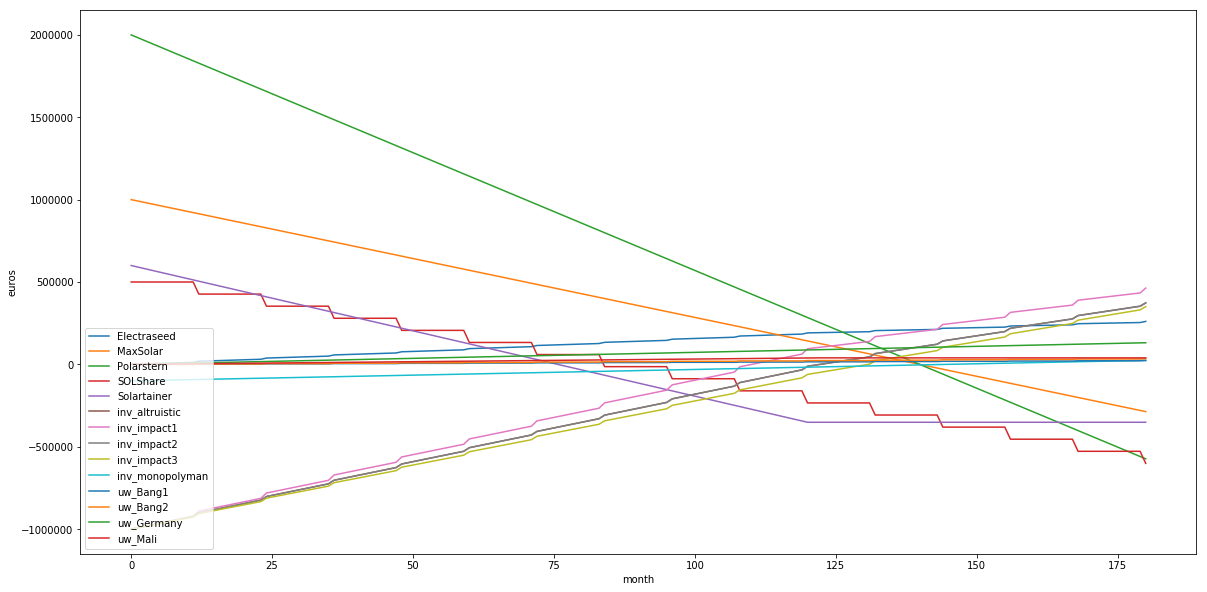

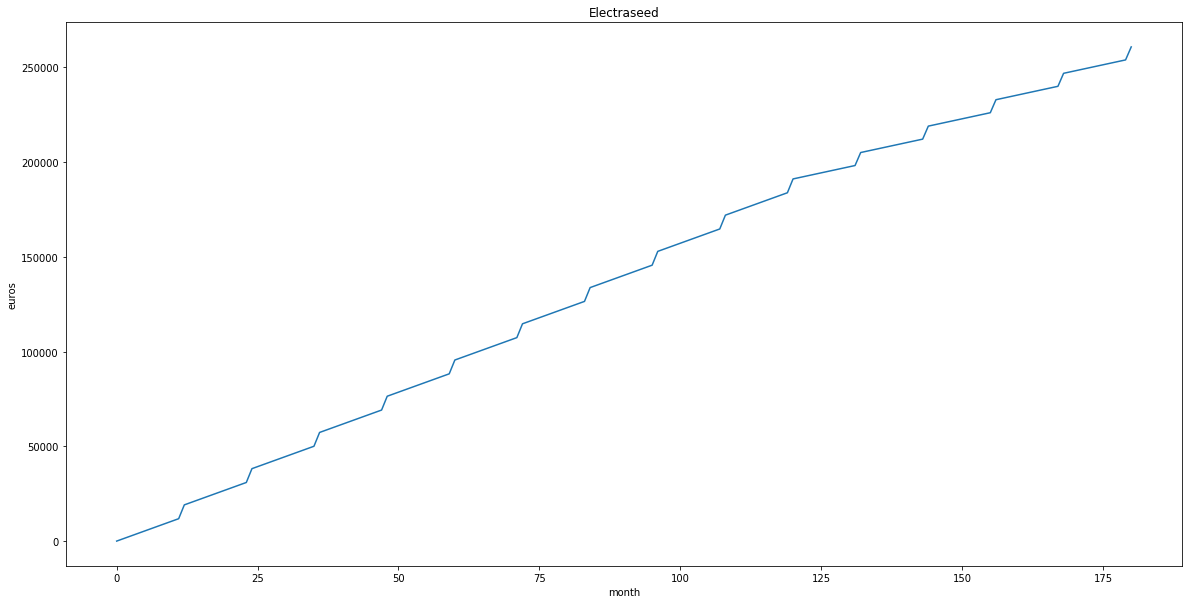

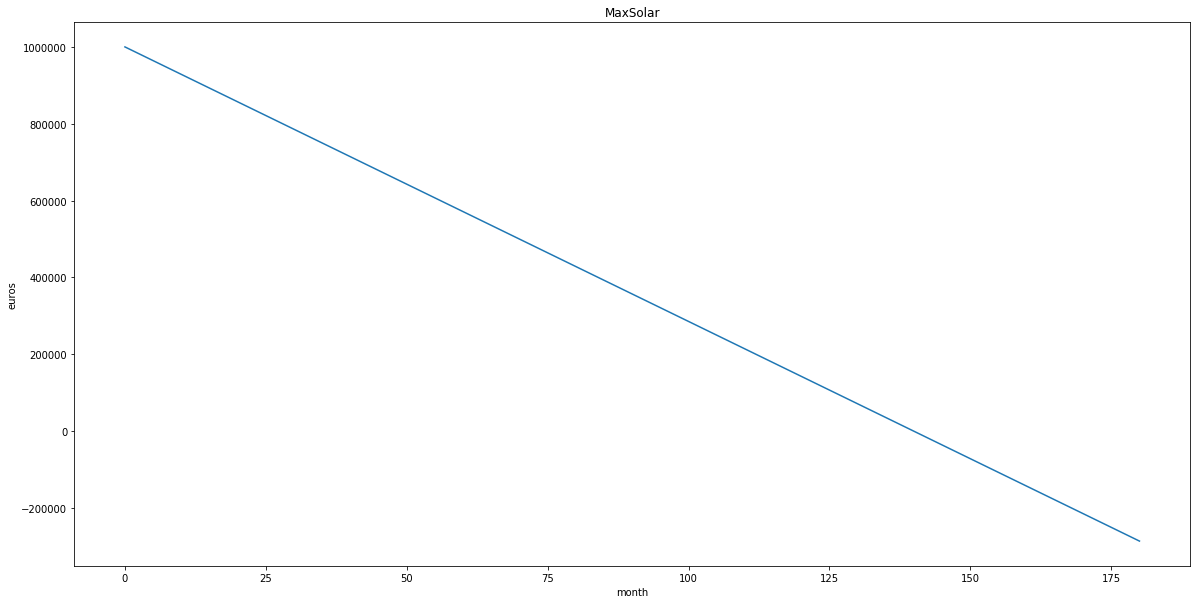

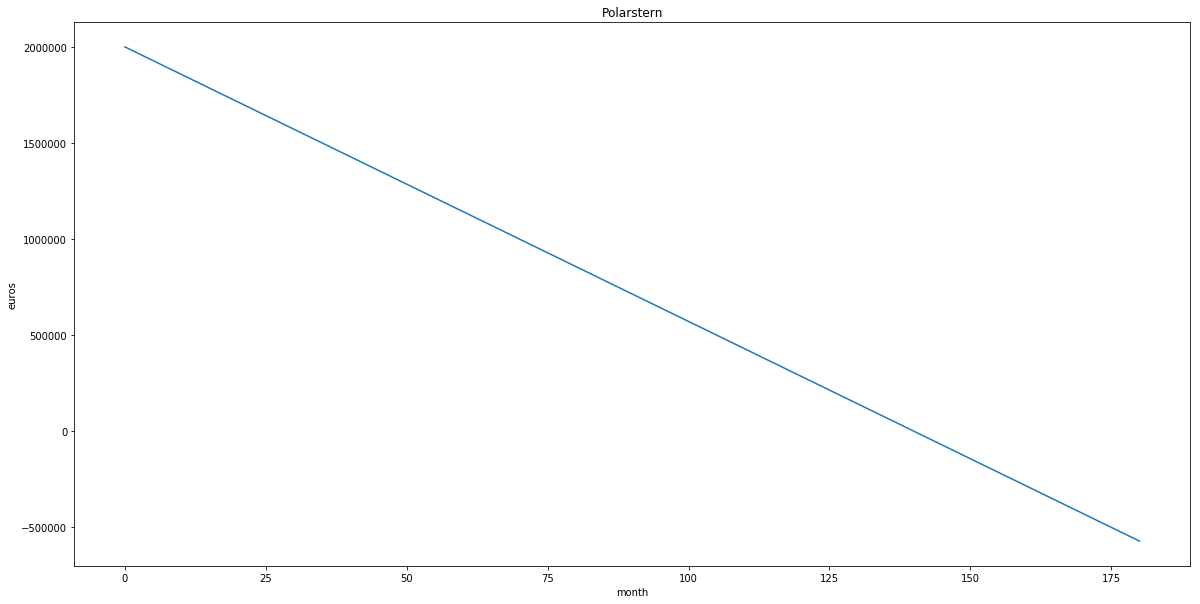

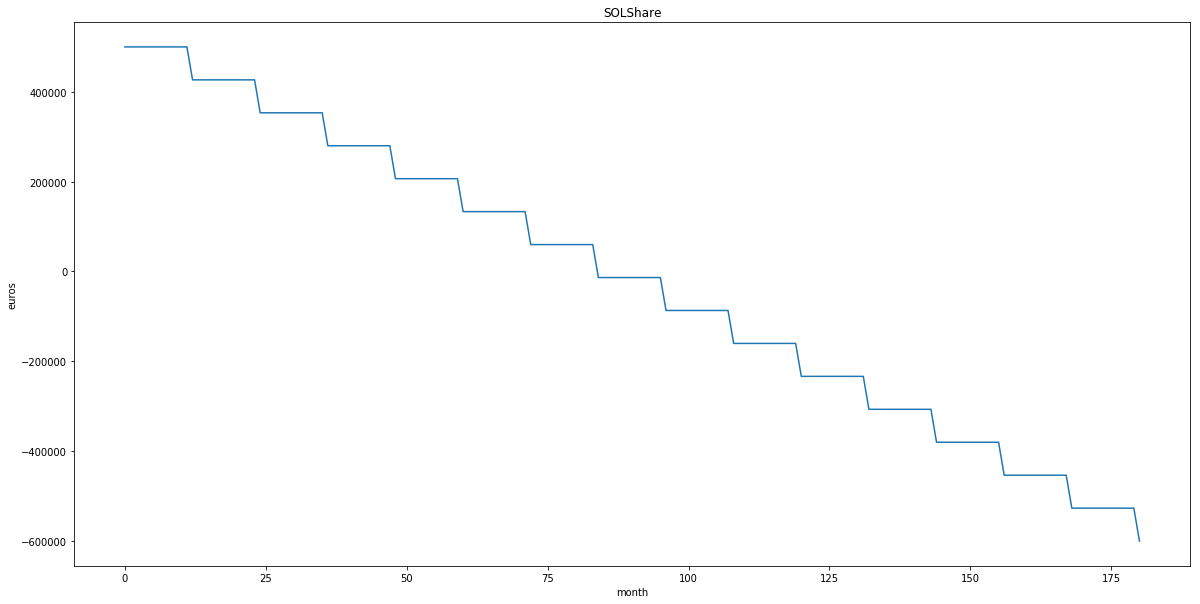

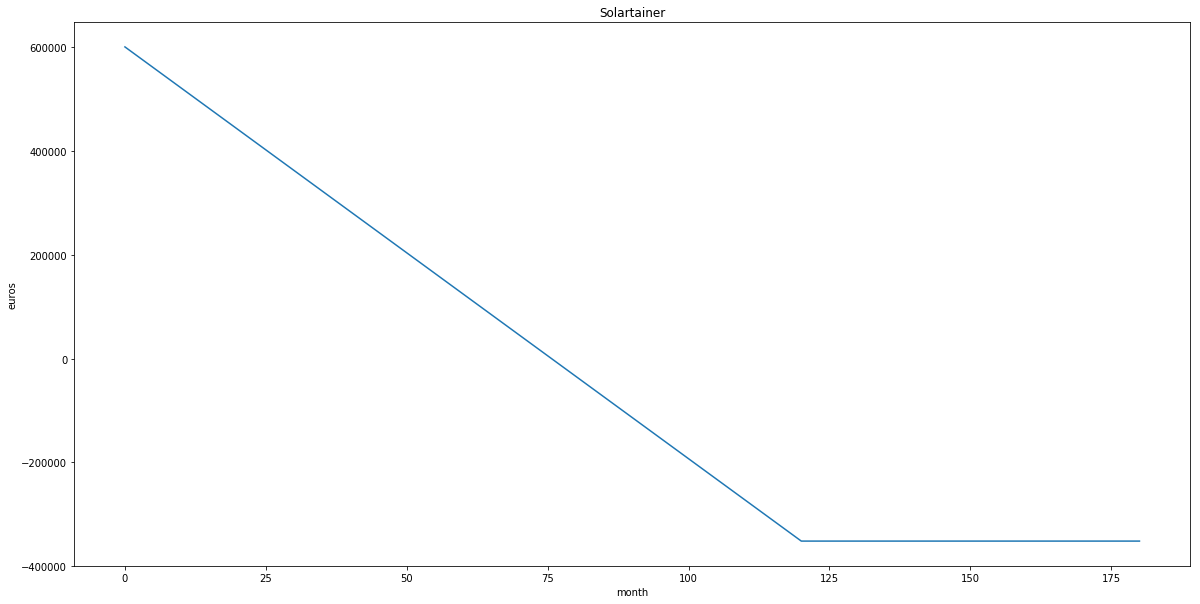

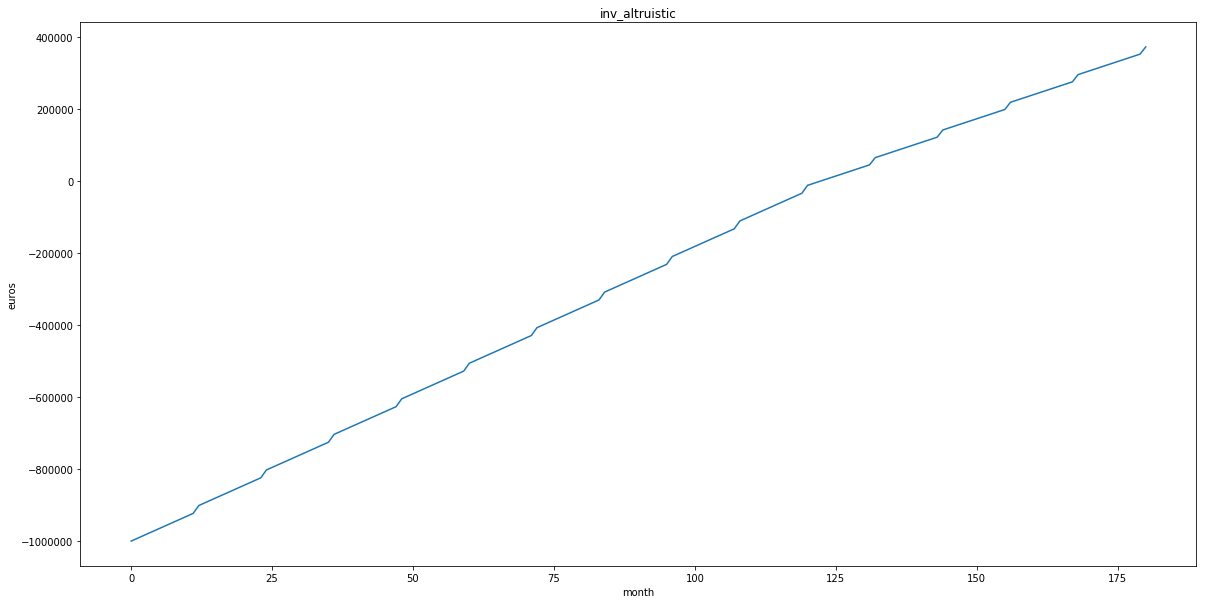

In [ ]:
# TODO make this pretty - decide what we want to plot. Maybe one chart for each investor?
plt.rcParams["figure.figsize"] = (20,10)

df_cumsum.plot(kind='line')
plt.xlabel('month')
plt.ylabel('euros')
plt.legend(loc=3, prop={'size': 10})
plt.show()

for i in df_cumsum.columns:
    plt.figure()
    plt.xlabel('month')
    plt.ylabel('euros')
    df_cumsum[i].plot(kind='line', title=i)